In [8]:
import pandas as pd
# import modin.pandas as mpd
import numpy as np
import datetime
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import mplfinance as mpf
from multiprocessing import Pool
from contextlib import contextmanager
from joblib import Parallel, delayed
from IPython.display import clear_output
# import dill as pickle
import pickle
import time

In [9]:
# causis api

#### Stock Data Preparation
The strategy is executed on identical base positions. In this case, the base positions are components of CSI 500.

+ CST500 components weights

In [10]:
index_weights = pd.read_pickle('./dataset/tmp_position.pkl')

Arrange_dates = list(index_weights['df_t0_trade'].loc[index_weights['df_t0_trade']==False].index)
Arrange_dates.append(pd.to_datetime('2022-07-08 00:00:00'))

stock_weights = index_weights['df_pos'].transpose()

In [11]:
Weight_Matrix = index_weights['df_pos'].transpose()

for d in Weight_Matrix.columns:
    Weight_Matrix[d] = Weight_Matrix[d] / Weight_Matrix[d].sum()

Weight_Matrix = Weight_Matrix.transpose()

+ Data of the base positions (daily, min_bars, price & volumes needed) has been prepared and is stored in ./CST500_1min.pkl.

In [12]:
Base_Pos = pd.read_pickle('./dataset/CSI500_minute1.pkl')

+ Data Patches

In [13]:
new_patch = False

## Omitted symbols in Local Data (potential)
for id in tqdm(Weight_Matrix.columns, desc='Patching1'):
    if id not in Base_Pos.keys():
        df = get_price(id, '2019-11-29', '2022-07-08', 'minute1')
        if df.shape[0]:
            df = df.set_index('CLOCK', drop=False)
            Base_Pos[id] = df
            new_patch = True
        else:
            Base_Pos[id] = df
            new_patch = True

## Column 'CLOCK' Error 1 (potential)
for symbol in tqdm(Base_Pos.keys(), desc='Patching2'):
    if Base_Pos[symbol].shape[0]:
        if isinstance(Base_Pos[symbol]['CLOCK'][0], float):
            Base_Pos[symbol]['CLOCK'] = list(Base_Pos[symbol].index)
            new_patch = True

## Column 'CLOCK' Error 2 (potential)
for symbol in tqdm(Base_Pos.keys(), desc='Patching3'):
    if Base_Pos[symbol].shape[0]:
        if isinstance(Base_Pos[symbol]['CLOCK'][0], int):
            df = get_price(str(symbol), '2019-11-29', '2022-07-08', 'minute1')
            if df.shape[0]:
                df = df.set_index('CLOCK', drop=False)
                Base_Pos[symbol] = df
                new_patch = True

if new_patch:
    with open('./dataset/CSI500_minute1.pkl', 'wb') as f:
        pickle.dump(Base_Pos, f, pickle.HIGHEST_PROTOCOL)
    print("New Patch")

else:
    print("No New Patch")

Patching3: 100%|██████████| 774/774 [00:00<00:00, 85997.12it/s]

No New Patch


#### Global Environment Variables
+ Global Settings of Strategy and Backtest Environment

In [14]:
## KDJ Indicator
KDJ_WIN = 9

## MACD Indicator
P_S_EMA_WIN = 12
P_L_EMA_WIN = 26
DEA_WIN = 9

## Super Trend Indicator
ATR_WIN = 60
STD_MULTIPLIER = 3

## BackTest & Simulation Parameters
ACCOUNT = 1e6

## Plot Settings
COLORS = ['darkorange', 'cyan', 'royalblue', 'deeppink', 'indianred', 'limegreen']

#### Technical Features
+ Function *technical_analysis* calculates all the technical features we need, most important of which are 3 signals and fluctuations.
+ Function *tri_forks_filter* aggregates above four features and generates execution signals.

In [15]:
@contextmanager 
def timer(name: str, _align, _log): # ⏱
    s = time.time()
    yield
    elapsed = time.time() - s
    if _log:
        print(f"{ '[' + name + ']' :{_align}} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done | Using {elapsed: .3f} seconds")

In [16]:
def technical_analysis(stmp, log = True):
    stmp = stmp.loc[~stmp['CLOCK'].duplicated()]
    ## Base Position Price
    stmp['BS_price'] = stmp['CLOSE'].shift(1)

    stmp['P_S_EMA'] = stmp['CLOSE'].ewm(span=45, min_periods=1).mean()
    stmp['P_L_EMA'] = stmp['CLOSE'].ewm(span=120, min_periods=1).mean()


    with timer('KDJ Indicator', 20, log):
        ## J line
        stmp['RSV'] = (stmp['CLOSE'] - stmp['LOW'].rolling(KDJ_WIN, min_periods=1).min().shift(1)) \
                    / (stmp['HIGH'].rolling(KDJ_WIN, min_periods=1).max().shift(1)-stmp['LOW'].rolling(KDJ_WIN, min_periods=1).min().shift(1))
        stmp['RSV'] = stmp['RSV'].replace([np.inf, -np.inf], np.nan).fillna(0.5)*100

        K_t = []
        D_t = []
        J_t = []
        K_t.append(50)
        D_t.append(50)
        J_t.append(50)

        for i in range(1, stmp.shape[0]):
            K_t.append(K_t[i-1]*2/3 + stmp['RSV'][i]/3)
            D_t.append(D_t[i-1]*2/3 + K_t[i]/3)
            J_t.append(3*K_t[i] - 2*D_t[i])

        stmp['J'] = J_t

    with timer('MACD', 20, log):
        ## MACD
        DIF = stmp['CLOSE'].ewm(span=P_S_EMA_WIN, adjust=False).mean() - stmp['CLOSE'].ewm(span=P_L_EMA_WIN, adjust=False).mean()
        DEA = DIF.ewm(span=DEA_WIN, adjust=False).mean()
        stmp['MACD'] = 2*(DIF - DEA)

        stmp['MACD_diff'] = np.sign(stmp['MACD'].diff()).fillna(0)
        stmp['MACD_color'] = np.zeros(stmp.shape[0])
        stmp['MACD_color'].loc[(stmp['MACD']>0) & (stmp['MACD_diff']>0)] =  1 # Deep Red
        stmp['MACD_color'].loc[(stmp['MACD']>0) & (stmp['MACD_diff']<0)] =  2 # Light Red
        stmp['MACD_color'].loc[(stmp['MACD']<0) & (stmp['MACD_diff']<0)] = -1 # Deep Green
        stmp['MACD_color'].loc[(stmp['MACD']<0) & (stmp['MACD_diff']>0)] = -2 # Light Green
        # for plotting
        stmp['MACD_dr'] = np.zeros(stmp.shape[0])
        stmp['MACD_lr'] = np.zeros(stmp.shape[0])
        stmp['MACD_dg'] = np.zeros(stmp.shape[0])
        stmp['MACD_lg'] = np.zeros(stmp.shape[0])
        stmp['MACD_dr'].loc[stmp['MACD_color']== 1] = stmp.loc[stmp['MACD_color']== 1]['MACD']
        stmp['MACD_lr'].loc[stmp['MACD_color']== 2] = stmp.loc[stmp['MACD_color']== 2]['MACD']
        stmp['MACD_dg'].loc[stmp['MACD_color']==-1] = stmp.loc[stmp['MACD_color']==-1]['MACD']
        stmp['MACD_lg'].loc[stmp['MACD_color']==-2] = stmp.loc[stmp['MACD_color']==-2]['MACD']


    with timer('Super Trend', 20, log):
        ## ATR
        TR = []
        TR.append(stmp['HIGH'][0] - stmp['LOW'][0])
        for i in range(1, stmp.shape[0]): 
            TR.append( max( stmp['HIGH'][i]-stmp['LOW'][i], np.abs(stmp['HIGH'][i]-stmp['CLOSE'][i-1]), np.abs(stmp['LOW'][i]-stmp['CLOSE'][i-1])) )

        stmp['TR'] = TR
        stmp['ATR'] = stmp['TR'].rolling(ATR_WIN, min_periods=1).mean() 

        ## Super Trend
        stmp['h12'] = (stmp['HIGH'] + stmp['LOW'])/2
        stmp['bub'] = stmp['h12'] + STD_MULTIPLIER*stmp['ATR']
        stmp['blb'] = stmp['h12'] - STD_MULTIPLIER*stmp['ATR']

        UB = []
        LB = []
        UB.append(stmp['bub'][0])
        LB.append(stmp['blb'][0])

        for i in range(1, stmp.shape[0]):
            if stmp['CLOSE'][i-1] > LB[i-1]:
                LB.append(max(stmp['blb'][i], LB[i-1]))
            else:
                LB.append(stmp['blb'][i])
            
            if stmp['CLOSE'][i-1] < UB[i-1]:
                UB.append(min(stmp['bub'][i], UB[i-1]))
            else:
                UB.append(stmp['bub'][i])

        STD = []
        STD.append(np.sign(stmp['CLOSE'][0] - stmp['OPEN'][0]))

        for i in range(1, stmp.shape[0]):
            if stmp['CLOSE'][i] > UB[i]:
                STD.append(1.0)
            elif stmp['CLOSE'][i] < LB[i]:
                STD.append(-1.0)
            else:
                STD.append(STD[i-1])

        stmp['UB'] = UB
        stmp['LB'] = LB
        stmp['STD'] = STD

        stmp['UB'].loc[stmp['STD']== 1.0] = np.nan # plot upper band during down trend
        stmp['LB'].loc[stmp['STD']==-1.0] = np.nan # plot lower band during up trend
        

    return stmp

In [626]:
ptmp = Base_Pos['S.CN.SZSE.300618']
ptmp = technical_analysis(ptmp)

[KDJ Indicator]      | 2022-08-12 11:25:01 Done | Using  1.743 seconds
[MACD]               | 2022-08-12 11:25:01 Done | Using  0.192 seconds
[Super Trend]        | 2022-08-12 11:25:14 Done | Using  12.437 seconds


#### Strategy

+ Time to open positions (BUY or SELL)

In [713]:
def Trend_activation(_stmp):
    
    def strT2float(_str):
        return float(_str.replace(":","").replace(" ", "").replace("-", ""))

    _stmp['Cluster_rank'] = [np.nan for _ in range(_stmp.shape[0])]
    _stmp['Cluster_rank'][0] = strT2float(_stmp['CLOCK'][0])

    cluster_div_condi = (np.sign(_stmp['MACD_color'])+np.sign(_stmp['MACD_color'].shift(1)) == 0) # when red-green bars change
    _stmp['Cluster_rank'].loc[cluster_div_condi] = _stmp.loc[cluster_div_condi]['CLOCK'].apply(lambda x: strT2float(x))
    _stmp['Cluster_rank'] = _stmp['Cluster_rank'].ffill()

    _stmp['execution'] = np.zeros(_stmp.shape[0])

    ## BUY Time
    buy_tt = []
    buy_condition = (ptmp['MACD_color']==1) & (ptmp['STD']==1) & (ptmp['J']>90) 
    for _, group in _stmp.loc[buy_condition].groupby('Cluster_rank'):
        buy_tt.append(group['CLOCK'][0])
        # buy_tt += group['CLOCK'].to_list()
    for bt in buy_tt:
        _stmp['execution'].loc[bt] = 1

    ## SELL Time
    sell_tt = []
    sell_condition = (_stmp['MACD_color']==-1) & (_stmp['STD']==-1) & (_stmp['J']<10)
    for _, group in _stmp.loc[sell_condition].groupby('Cluster_rank'):
        sell_tt.append(group['CLOCK'][0])
        # sell_tt += group['CLOCK'].to_list()
    for st in sell_tt:
        _stmp['execution'].loc[st] = -1

    return _stmp
    

In [714]:
ptmp = Trend_activation(ptmp)

+ Strategy

In [715]:
def solid_bar_time(_date, _time):
    if (_date + ' 11:30:00' < _time) and (_time < _date + ' 13:00:00'):
        _time = str(pd.to_datetime(_time) + datetime.timedelta(hours=1, minutes=30))

    if _time == _date + ' 13:00:00':
        _time = str(pd.to_datetime(_time) + datetime.timedelta(minutes=1))
                
    return _time

In [716]:
buy_exe_t  = list(ptmp['execution'].loc[ptmp['execution']== 1].index)
sell_exe_t = list(ptmp['execution'].loc[ptmp['execution']==-1].index)

buy_log = pd.DataFrame(columns=['Open_Clock', 'Close_Clock', 'open_price', 'close_price'])
for exe_t in tqdm(buy_exe_t, desc='Buy Execution'):

    if exe_t >= exe_t[:10] + ' 14:55:00': # do not use late signals
        continue

    loss_cut = ptmp.loc[exe_t]['HIGH'] # initial loss cut equals to lowest price of the signal bar
    open_bar = str(pd.to_datetime(exe_t)+datetime.timedelta(minutes=1))
    open_bar = solid_bar_time(exe_t[:10], open_bar)

    if ptmp.loc[open_bar]['OPEN'] > loss_cut: # Open Position Successfully
        open_price = ptmp.loc[open_bar]['OPEN']

        close_bar = open_bar
        ## Longest Holding period: inf minutes
        for i in range(10000):
            ht = str(pd.to_datetime(open_bar)+datetime.timedelta(minutes=i))
            ht = solid_bar_time(exe_t[:10], ht)

            if ht >= exe_t[:10] + ' 14:55:00': # day out
                close_bar = exe_t[:10] + ' 14:55:00'
                break

            if ptmp.loc[ht]['CLOSE'] < loss_cut: # lower than loss tolerance level
                close_bar = ht
                break

            if (ptmp.loc[ht]['J'] < 75): # J is too large or too small
                loss_cut = max(loss_cut, ptmp.loc[ht]['LOW'])

            if ptmp.loc[ht]['MACD_color'] == -1: # Deep Green bars indicate the time to change loss cut
                loss_cut = max(loss_cut, ptmp.loc[ht]['LOW'])

            if ht in buy_exe_t: # no appendant position before closing
                del buy_exe_t[buy_exe_t.index(ht)]
                
        close_bar = str(pd.to_datetime(close_bar)+datetime.timedelta(minutes=1))
        close_bar = solid_bar_time(exe_t[:10], close_bar)  
        close_price = ptmp.loc[close_bar]['OPEN'] # Close position using OPEN of bar_{t+1}

        buy_log.loc[buy_log.shape[0]] = [open_bar, close_bar, open_price, close_price]

    else:
        continue 

sell_log = pd.DataFrame(columns=['Open_Clock', 'Close_Clock', 'open_price', 'close_price'])
for exe_t in tqdm(sell_exe_t, desc='Sell Execution'):

    if exe_t >= exe_t[:10] + ' 14:55:00': # do not use late signals
        continue

    loss_cut = ptmp.loc[exe_t]['LOW'] # initial loss cut equals to lowest price of the signal bar
    open_bar = str(pd.to_datetime(exe_t)+datetime.timedelta(minutes=1))
    open_bar = solid_bar_time(exe_t[:10], open_bar)

    if ptmp.loc[open_bar]['OPEN'] < loss_cut: # Open Position Successfully
        open_price = ptmp.loc[open_bar]['OPEN']

        close_bar = open_bar
        ## Longest Holding period: inf minutes
        for i in range(10000):
            ht = str(pd.to_datetime(open_bar)+datetime.timedelta(minutes=i))
            ht = solid_bar_time(exe_t[:10], ht)

            if ht >= exe_t[:10] + ' 14:55:00': # day out
                close_bar = exe_t[:10] + ' 14:55:00'
                break

            if ptmp.loc[ht]['CLOSE'] > loss_cut: # lower than loss tolerance level
                close_bar = ht
                break

            if (ptmp.loc[ht]['J'] > 50): # J is too large or too small
                loss_cut = min(loss_cut, ptmp.loc[ht]['HIGH'])

            if ptmp.loc[ht]['MACD_color'] == 1: # Deep Green bars indicate the time to change loss cut
                loss_cut = max(loss_cut, ptmp.loc[ht]['HIGH'])

            if ht in sell_exe_t: # no appendant position before closing
                del sell_exe_t[sell_exe_t.index(ht)]
                
        close_bar = str(pd.to_datetime(close_bar)+datetime.timedelta(minutes=1))
        close_bar = solid_bar_time(exe_t[:10], close_bar)  
        close_price = ptmp.loc[close_bar]['OPEN'] # Close position using OPEN of bar_{t+1}

        sell_log.loc[sell_log.shape[0]] = [open_bar, close_bar, open_price, close_price]

    else:
        continue 

Sell Execution:  99%|█████████▉| 5055/5094 [00:10<00:00, 467.34it/s]


In [636]:
buy_log

,Open_Clock,Close_Clock,open_price,close_price,gain_fee,gain_feeless,Date
0,2019-06-11 13:08:00,2019-06-11 13:14:00,61.44,61.50,0.035412,0.06,2019-06-11
1,2019-06-11 13:53:00,2019-06-11 13:57:00,62.01,61.95,-0.084792,-0.06,2019-06-11
2,2019-06-17 09:59:00,2019-06-17 10:03:00,61.33,61.13,-0.224492,-0.20,2019-06-17
3,2019-07-01 13:07:00,2019-07-01 13:13:00,60.75,60.80,0.025690,0.05,2019-07-01
4,2019-07-02 10:08:00,2019-07-02 10:10:00,62.54,62.38,-0.184984,-0.16,2019-07-02
...,...,...,...,...,...,...,...
552,2022-06-28 10:47:00,2022-06-28 11:01:00,59.96,60.10,0.115988,0.14,2022-06-28
553,2022-06-28 14:21:00,2022-06-28 14:32:00,60.41,60.36,-0.074154,-0.05,2022-06-28
554,2022-06-30 11:11:00,2022-06-30 11:20:00,58.32,58.23,-0.113310,-0.09,2022-06-30
555,2022-07-01 13:35:00,2022-07-01 13:43:00,58.42,58.40,-0.043364,-0.02,2022-07-01


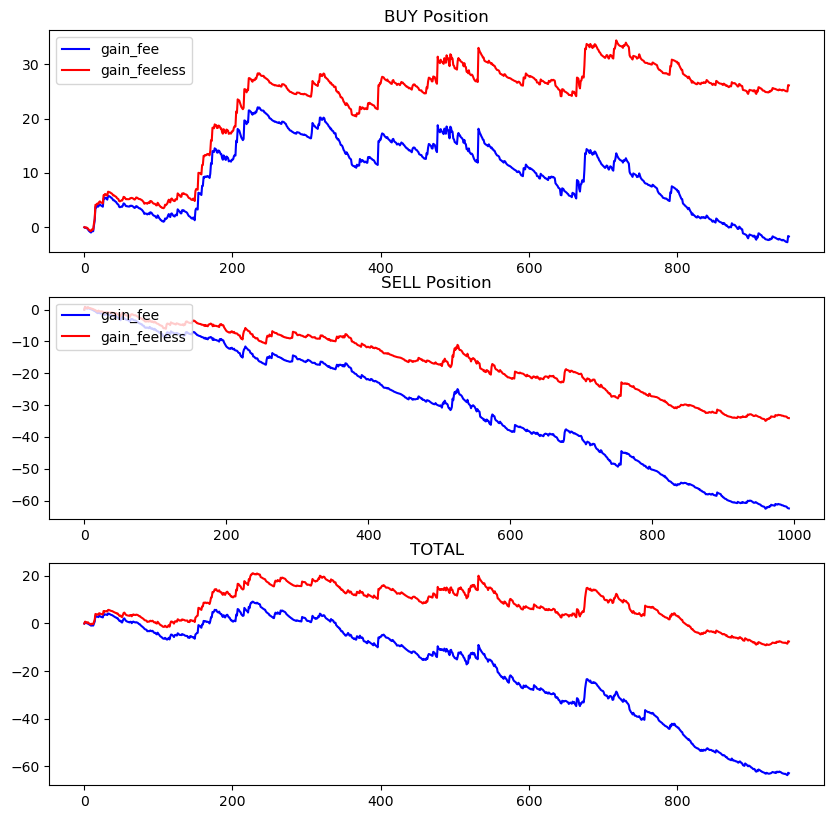

In [717]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), dpi=100)

axes[0].set_title('BUY Position')
buy_log['gain_fee'] = (buy_log['close_price'] - buy_log['open_price']) - (buy_log['close_price'] + buy_log['open_price'])*2e-4
buy_log['gain_feeless'] = (buy_log['close_price'] - buy_log['open_price'])

buy_log['gain_fee'].cumsum()[:].plot(color='b', ax=axes[0])
buy_log['gain_feeless'].cumsum()[:].plot(color='r', ax=axes[0])
axes[0].legend(loc='upper left')

axes[1].set_title('SELL Position')
sell_log['gain_fee'] = (sell_log['open_price'] - sell_log['close_price']) - (sell_log['close_price'] + sell_log['open_price'])*2e-4
sell_log['gain_feeless'] = (sell_log['open_price'] - sell_log['close_price'])

sell_log['gain_fee'].cumsum()[:].plot(color='b', ax=axes[1])
sell_log['gain_feeless'].cumsum()[:].plot(color='r', ax=axes[1])
axes[1].legend(loc='upper left')

axes[2].set_title('TOTAL')
(buy_log['gain_fee'].cumsum()+sell_log['gain_fee'].cumsum()).plot(color='b', ax=axes[2])
(buy_log['gain_feeless'].cumsum()+sell_log['gain_feeless'].cumsum()).plot(color='r', ax=axes[2])

In [718]:
buy_log['Date'] = buy_log['Open_Clock'].apply(lambda x: x[:10])
sell_log['Date'] = sell_log['Open_Clock'].apply(lambda x: x[:10])

trading_log = pd.DataFrame()
trading_log = trading_log.reindex(Weight_Matrix.index)
trading_log['BUY_gain_fee'] = np.zeros(trading_log.shape[0])

trading_log['BUY_gain_feeless'] = np.zeros(trading_log.shape[0])
trading_log['SELL_gain_fee'] = np.zeros(trading_log.shape[0])
trading_log['SELL_gain_feeless'] = np.zeros(trading_log.shape[0])

for name, group in buy_log.groupby('Date'):
    trading_log['BUY_gain_fee'].loc[name] = group['gain_fee'].sum()
    trading_log['BUY_gain_feeless'].loc[name] = group['gain_feeless'].sum()

for name, group in sell_log.groupby('Date'):
    trading_log['SELL_gain_fee'].loc[name] = group['gain_fee'].sum()
    trading_log['SELL_gain_feeless'].loc[name] = group['gain_feeless'].sum()

trading_log['TOTAL_gain_fee'] = trading_log['BUY_gain_fee'] + trading_log['SELL_gain_fee']
trading_log['TOTAL_gain_feeless'] = trading_log['BUY_gain_feeless'] + trading_log['SELL_gain_feeless']

# Base Position
trading_log['BS'] = np.zeros(trading_log.shape[0])
for date in Weight_Matrix.index:
    trading_log['BS'].loc[date] = 1e8/ptmp.loc[str(date)[:10]+' 09:31:00']['BS_price']

for col in trading_log.columns[:-1]:
    trading_log[col] = trading_log[col]*trading_log['BS']*0.1

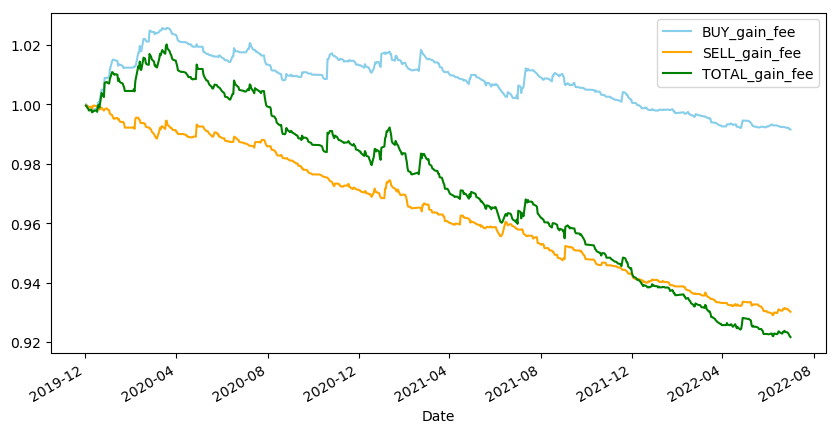

In [719]:
BUY_fee_pnl = (1 + trading_log['BUY_gain_fee'].cumsum()/1e8)
BUY_feeless_pnl = (1 + trading_log['BUY_gain_feeless'].cumsum()/1e8)

SELL_fee_pnl = (1 + trading_log['SELL_gain_fee'].cumsum()/1e8)
SELL_feeless_pnl = (1 + trading_log['SELL_gain_feeless'].cumsum()/1e8)

TOTAL_fee_pnl = (1 + trading_log['TOTAL_gain_fee'].cumsum()/1e8)
TOTAL_feeless_pnl = (1 + trading_log['TOTAL_gain_feeless'].cumsum()/1e8)

plt.figure(figsize=(10, 5), dpi=100)

BUY_fee_pnl.plot(color='skyblue')
SELL_fee_pnl.plot(color='orange')
TOTAL_fee_pnl.plot(color='green')

plt.legend()

In [465]:
list(trading_log['BUY_gain_fee']).index(trading_log['BUY_gain_fee'].max())

295

In [723]:
trading_log['BUY_gain_fee'].sort_values()

Date
2021-09-02   -225006.685552
2021-07-06   -219073.088905
2021-01-14   -186949.859917
2020-02-13   -173135.533553
2020-05-07   -173029.111240
                  ...      
2020-12-31    440296.971077
2021-07-02    448522.829243
2021-07-12    624724.700537
2020-10-20    664569.841025
2021-02-22    712848.360656
Name: BUY_gain_fee, Length: 626, dtype: float64

In [720]:
trading_log['SELL_gain_fee'].sort_values()

Date
2021-07-28   -186858.595194
2021-02-04   -175355.536079
2021-01-25   -172148.541608
2021-03-05   -169954.539959
2021-03-26   -149736.503067
                  ...      
2020-02-06    323993.137629
2021-01-05    325558.418568
2021-06-15    398215.564202
2020-04-28    409906.896552
2021-09-03    437964.896490
Name: SELL_gain_fee, Length: 626, dtype: float64

In [690]:
sell_holding = sell_log['Close_Clock'].apply(lambda x: pd.to_datetime(x)) - sell_log['Open_Clock'].apply(lambda x: pd.to_datetime(x))
sell_hold = sell_holding.apply(lambda x: int(str(x)[-8:-6])*60 + int(str(x)[-5:-3]))

In [691]:
sell_hold.describe()

count    618.000000
mean       7.996764
std       15.114152
min        1.000000
25%        1.000000
50%        3.000000
75%        9.750000
max      120.000000
dtype: float64

Text(0.5,1,'V1.0.2 SELL')

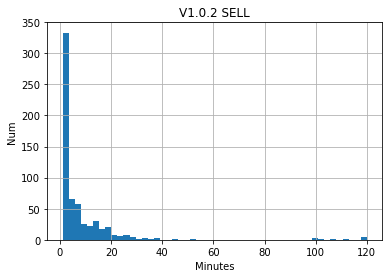

In [711]:
sell_hold.hist(bins=50)
plt.xlabel('Minutes')
plt.ylabel('Num')
plt.title('V1.0.2 SELL')

In [476]:
buy_log.loc[buy_log['Open_Clock']>'2020-07-30 09:31:00'][:]

,Open_Clock,Close_Clock,open_price,close_price,gain_fee,gain_feeless,Date
465,2020-07-30 09:32:00,2020-07-30 09:33:00,78.50,78.03,-0.501306,-0.47,2020-07-30
466,2020-07-30 09:34:00,2020-07-30 09:35:00,78.60,77.78,-0.851276,-0.82,2020-07-30
467,2020-07-30 10:28:00,2020-07-30 10:32:00,76.70,76.26,-0.470592,-0.44,2020-07-30
468,2020-07-30 10:36:00,2020-07-30 10:42:00,77.45,77.01,-0.470892,-0.44,2020-07-30
469,2020-08-03 11:09:00,2020-08-03 11:17:00,72.41,72.46,0.021026,0.05,2020-08-03
...,...,...,...,...,...,...,...
1382,2022-07-05 14:25:00,2022-07-05 14:41:00,62.73,63.90,1.144674,1.17,2022-07-05
1383,2022-07-06 09:43:00,2022-07-06 09:51:00,64.78,64.80,-0.005916,0.02,2022-07-06
1384,2022-07-06 10:06:00,2022-07-06 10:14:00,66.55,66.73,0.153344,0.18,2022-07-06
1385,2022-07-06 13:13:00,2022-07-06 13:14:00,66.48,66.50,-0.006596,0.02,2022-07-06


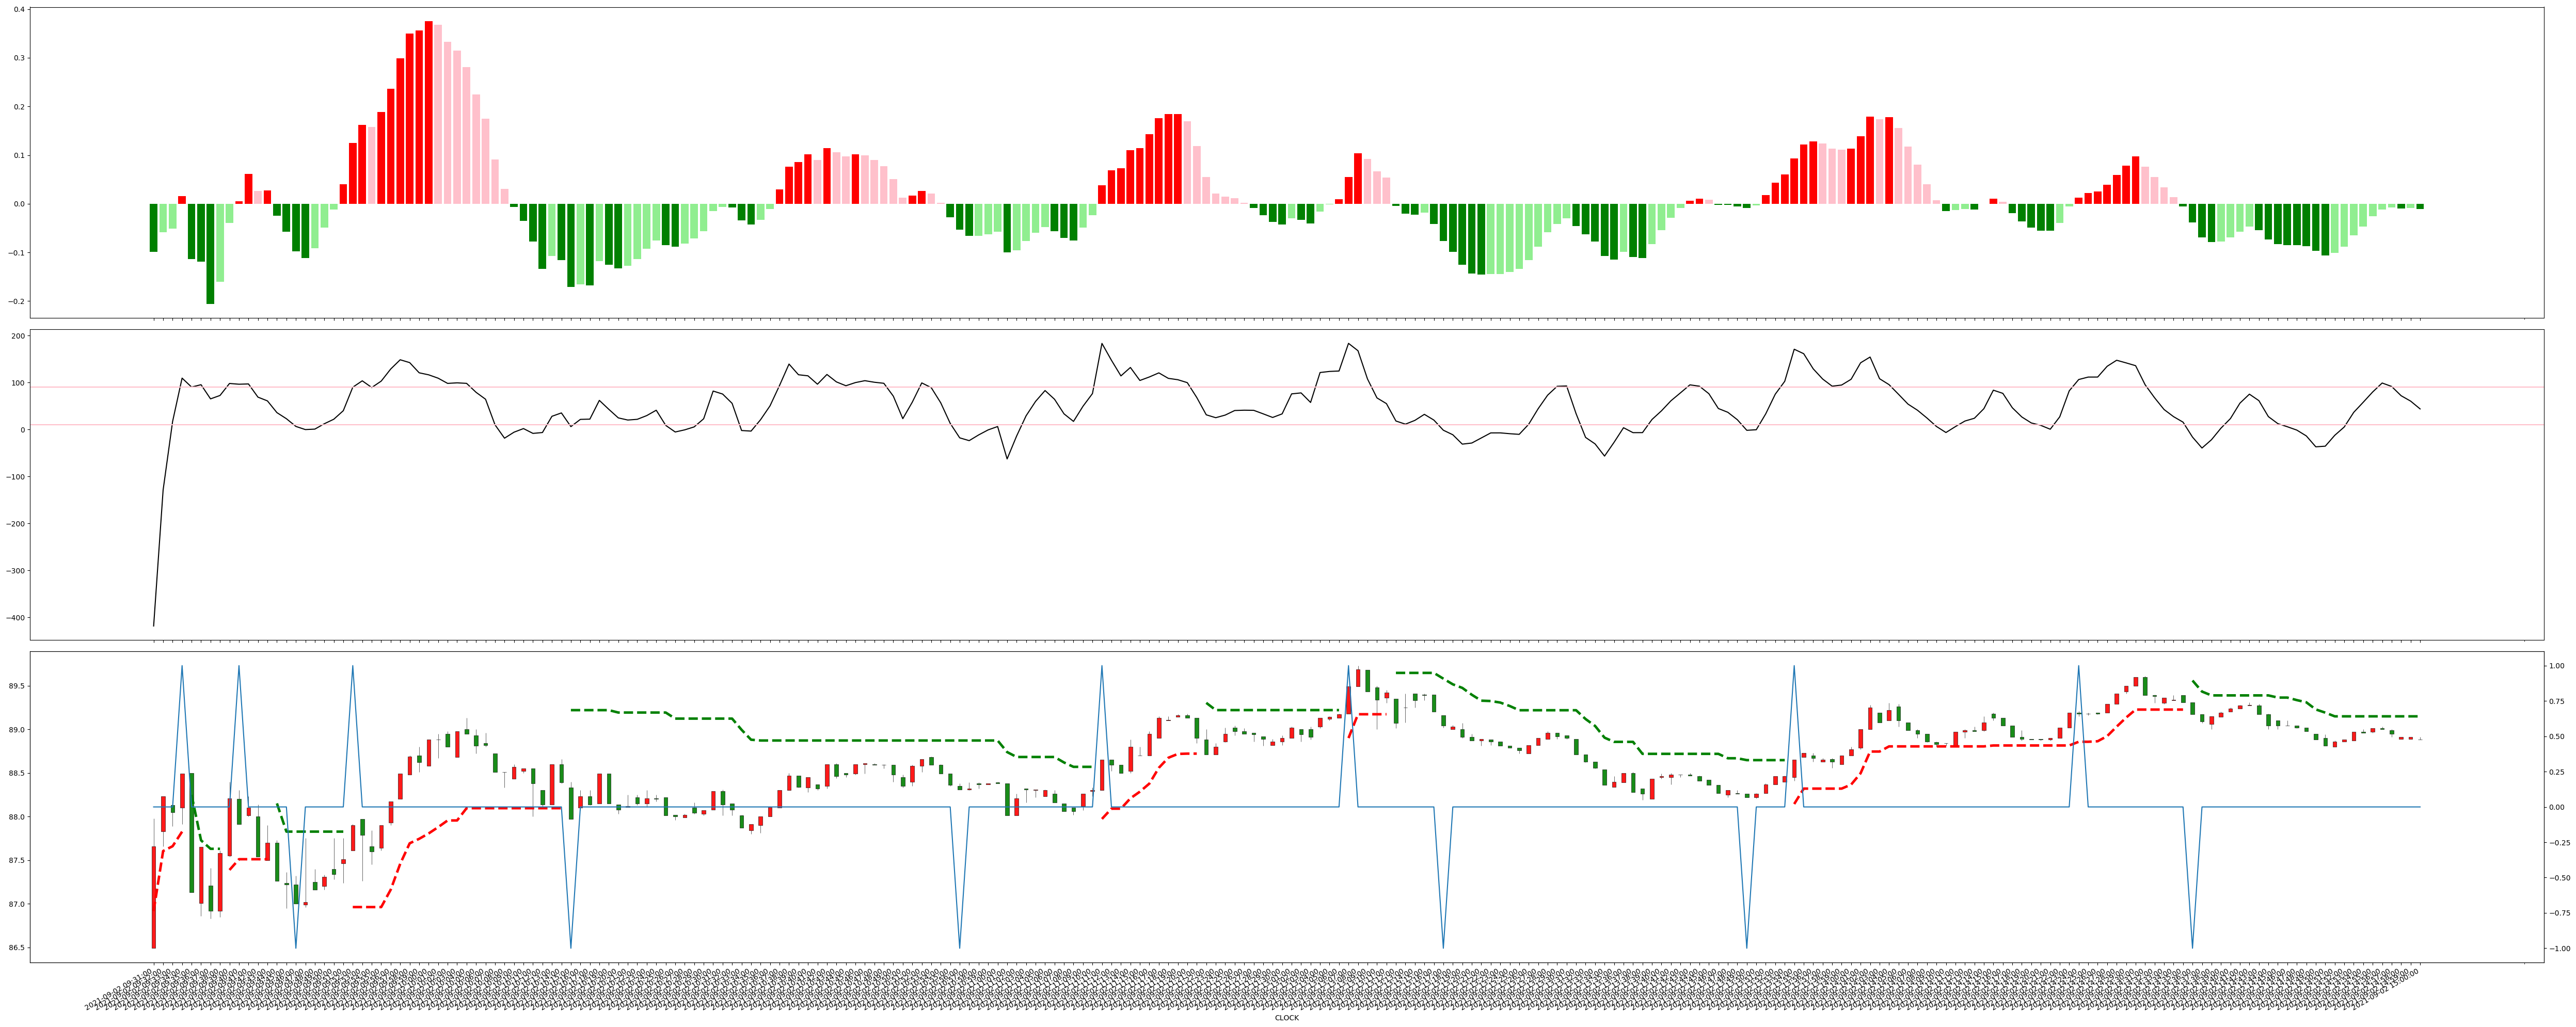

In [727]:
tmp_plot(ptmp, '2021-09-02 09:31:00','2021-09-02 15:00:00')

In [647]:
sell_log['gain_fee'].loc[sell_log['gain_fee']>0].shape[0]/sell_log['gain_fee'].shape[0]

0.20550161812297735

Temp Plot Function

In [721]:
def tmp_plot(ptmp, t1, t2):
    smp_slice = ptmp.loc[t1: t2]
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(50, 20), dpi=100, sharex=True)

    axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_dr'], color = 'red')
    axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_lr'], color = 'pink')
    axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_dg'], color = 'green')
    axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_lg'], color = 'lightgreen')

    smp_slice['J'].plot(ax = axes[1], color='black')
    axes[1].axhline(y=90, color='pink')
    axes[1].axhline(y=10, color='pink')

    # ptmp['UB'].loc[ptmp['STD']==-1.0] = np.nan
    # ptmp['LB'].loc[ptmp['STD']==1.0] = np.nan
    smp_slice['UB'].plot(ax=axes[2], color='g', linewidth=3.5, linestyle='--')
    smp_slice['LB'].plot(ax=axes[2], color='r', linewidth=3.5, linestyle='--')

    # ptmp['CLOSE'].loc[180:280].plot(ax=axes, color='b')
    sdf = pd.DataFrame()
    sdf['CLOCK'] = smp_slice['CLOCK'].apply(lambda x: pd.to_datetime(x))
    sdf = sdf.set_index('CLOCK')
    sdf['Open'] = smp_slice['OPEN']
    sdf['Close'] = smp_slice['CLOSE']
    sdf['High'] = smp_slice['HIGH']
    sdf['Low'] = smp_slice['LOW']
    sdf['Volume'] = smp_slice['VOLUME']

    mc = mpf.make_marketcolors(up='red', down='green', edge='black')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, y_on_right=False)

    mpf.plot(sdf, ax = axes[2], type='candle', style = s, ylabel='')

    # smp_slice['P_S_EMA'].plot(ax=axes[2], color='orange', alpha=0.6)
    # smp_slice['P_L_EMA'].plot(ax=axes[2], color='purple', alpha=0.6)

    ax_twin = axes[2].twinx()
    smp_slice['execution'].plot(ax=ax_twin)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

### BackTest

##### Single Symbol Simulation
+ Take 'S.CN.SZSE.300618', a relatively active stock for example

##### Base Position Simulation
+ Simulate all symbols contained in base positions
+ Divide symbols into several batches and use joblib to parallelize the simulation

In [14]:
# BATCH_SIZE = 128 # Do not put all eggs in signal bucket
# res = []
# ## Parallel BackTest
# tasks = []
# for i in range(3, (len(Weight_Matrix.columns)//BATCH_SIZE + 1)):
#     with timer(f'Batch {i}: {BATCH_SIZE*i:3} -- {min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))-1:3}', 20, True):
#         for col in Weight_Matrix.columns[BATCH_SIZE*i:min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))]:
#             stmp_ = Base_Pos[col]
#             one_stock_simulation(col, stmp_, True)

In [15]:
# BATCH_SIZE = 128 # Do not put all eggs in one signal bucket
# res = []
# ## Parallel BackTest
# tasks = []
# for i in range(3, (len(Weight_Matrix.columns)//BATCH_SIZE + 1)):
#     with timer(f'Batch {i}: {BATCH_SIZE*i:3} -- {min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))-1:3}', True):
#         for col in Weight_Matrix.columns[BATCH_SIZE*i:min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))]:
#             stmp_ = Base_Pos[col]
#             tasks.append(delayed(one_stock_simulation)(col, stmp_))

#         multi_work = Parallel(n_jobs=-1)
#         res += multi_work(tasks)

In [16]:
# ## Check SYMBOL Order
# Rank_Order = True
# for a, b in zip(res, Weight_Matrix.columns):
#     if a[0] != b:
#         print(f'{a[0]} != {b}') 
#         Rank_Order = False
#         break
# else:
#     print('All Ranks Correct')

# Pos_Fork_Gains = pd.DataFrame()
# Pos_Fork_Gains = Pos_Fork_Gains.reindex(Weight_Matrix.index)

# Neg_Fork_Gains = pd.DataFrame()
# Neg_Fork_Gains = Neg_Fork_Gains.reindex(Weight_Matrix.index)

# Total_Gains = pd.DataFrame()
# Total_Gains = Total_Gains.reindex(Weight_Matrix.index)

# if Rank_Order:
#     ## Allocate Results
#     for item in res:
#         Pos_Fork_Gains[item[0]] = item[1][0]
#         Neg_Fork_Gains[item[0]] = item[1][1]
#         Total_Gains[item[0]] = item[1][2]

#     Pos_Fork_Gains_BS = pd.DataFrame(Pos_Fork_Gains.values * Weight_Matrix.values)
#     Neg_Fork_Gains_BS = pd.DataFrame(Neg_Fork_Gains.values * Weight_Matrix.values)
#     Total_Gains_BS = pd.DataFrame(Total_Gains.values * Weight_Matrix.values)

##### Basic Analysis

+ Pnl

+ Win Rate

In [305]:
def cal_win_rate(_trading_log):
    daily_pos_fork_winrate = []
    daily_neg_fork_winrate = []

    pos_win = []
    pos_lose = []
    neg_win = []
    neg_lose = []

    for i in range(_trading_log.shape[0]):
        if _trading_log['pos_fork_gains'][i].shape[0]:
            _slice = _trading_log['pos_fork_gains'][i]
            daily_pos_fork_winrate.append(len(_slice.loc[_slice>0])/len(_slice))
            pos_win += list(_slice.loc[_slice>0])
            pos_lose += list(_slice.loc[_slice<0])
            
        if _trading_log['neg_fork_gains'][i].shape[0]:
            _slice = _trading_log['neg_fork_gains'][i]
            daily_neg_fork_winrate.append(len(_slice.loc[_slice>0])/len(_slice))
            neg_win += list(_slice.loc[_slice>0])
            neg_lose += list(_slice.loc[_slice<0])

    return daily_pos_fork_winrate, daily_neg_fork_winrate, (pos_win, pos_lose), (neg_win, neg_lose)

In [176]:
dpw, dnw, tpwl, tnwl = cal_win_rate(tmp_t_log)

In [177]:
print(f'Pos Fork Win Rate: {round(len(tpwl[0])/(len(tpwl[0])+len(tpwl[1])), 4)}')
print(f'Pos Fork Win-Loss Ratio: {round(np.abs(sum(tpwl[0]) / sum(tpwl[1])), 4)}\n')

print(f'Neg Fork Win Rate: {round(len(tnwl[0])/(len(tnwl[0])+len(tnwl[1])), 4)}')
print(f'Neg Fork Win-Loss Ratio: {round(np.abs(sum(tnwl[0]) / sum(tnwl[1])), 4)}\n')

print(f'Total Win Rate: {round((len(tpwl[0])+len(tnwl[0]))/(len(tpwl[0])+len(tpwl[1]) + len(tnwl[0])+len(tnwl[1])), 4)}')
print(f'Total Win-Loss Ratio: {round(np.abs((sum(tpwl[0]) + sum(tnwl[0]))/(sum(tpwl[1]) + sum(tnwl[1]))), 4)}')

Pos Fork Win Rate: 0.381
Pos Fork Win-Loss Ratio: 0.8207

Neg Fork Win Rate: 0.4076
Neg Fork Win-Loss Ratio: 0.7424

Total Win Rate: 0.3943
Total Win-Loss Ratio: 0.781


Text(0.5,1,'Neg Fork Win Rate')

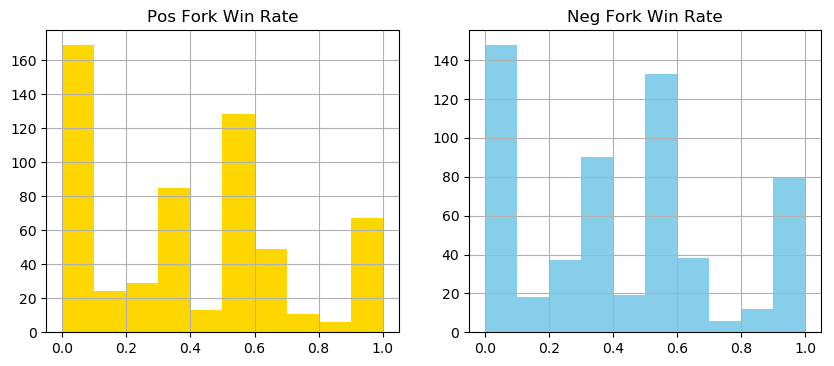

In [178]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
pd.Series(dpw).hist(ax=axes[0], color='gold')
axes[0].set_title('Pos Fork Win Rate')
pd.Series(dnw).hist(ax=axes[1], color='skyblue')
axes[1].set_title('Neg Fork Win Rate')
# plt.suptitle('Having Filter, Having Fees')

In [704]:
def profitable_analysis(_pnl):
    Annual_r = (_pnl.diff()/_pnl.shift(1)).mean()*252
    Std = (_pnl.diff()/_pnl.shift(1)).std()*np.sqrt(252)
    Sharpe = Annual_r / Std
    MaxDrawdown = (1 - list(_pnl)/pd.Series(list(_pnl.rolling(len(_pnl), min_periods=1))).apply(lambda x: x.max())).max()
    Calmar = Annual_r / MaxDrawdown
    return Annual_r, Std, Sharpe, MaxDrawdown, Calmar

In [705]:
profitable_analysis(TOTAL_fee_pnl)

(-0.00826829834112395,
 0.013486465761469613,
 -0.6130811798556005,
 0.043264408920933195,
 -0.1911108587253434)

In [706]:
profitable_analysis(BUY_fee_pnl)

(0.005869402601795481,
 0.011095347415226418,
 0.5289967390963131,
 0.013313035648894078,
 0.4408763528161254)

In [707]:
profitable_analysis(SELL_fee_pnl)

(-0.014349521457269147,
 0.007640076214073447,
 -1.8781908786245518,
 0.038198130001110275,
 -0.37566031260828897)